# Template

In [1]:
import os
import random
from contextlib import redirect_stdout
import pandas as pd
import descartes
import geopandas as gpd
import shapely
from shapely.geometry import Point, Polygon
from shapely import geometry

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense  
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical

/home/sciapps/Documents/Repos/tfm/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sciapps/Documents/Repos/tfm/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sciapps/Documents/Repos/tfm/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sciapps/Documents/Repos/tfm/env

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn import preprocessing

In [4]:
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

## Getting and describing the data

In [99]:
def get_local_repository_path(repository_name):
    """
    Return local absolute path from home directory
    to the repository folder (including it).
    Arg.: Name of the repository.
    """
    wd_path = os.getcwd()
    split_wd_path = wd_path.split("/")
    tfm_position = split_wd_path.index(repository_name)
    local_path_split = split_wd_path[:tfm_position+1]
    return "/".join(local_path_split)

In [100]:
# CONFIGURE
local_path = get_local_repository_path("tfm")
model_name = "2H_LR001_500_50PT" # Number of hidden layers, learning rate, epochs, checkout patience.

In [101]:
# OUTPUTS
save_dir = os.path.join(os.path.abspath(os.getcwd()), "outputs", model_name)
# Create outputs folder
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)

In [102]:
# DATA SET DIRECTORY
source_dir = "data/geodata/preprocessing/outputs"
# Importing the dataset
full_dataset = pd.read_csv(os.path.join(local_path, source_dir, "filtered_coordinates.csv"))
full_dataset.sample(n=5)

,species_name,latitude,longitude,coordinate_uncertainty
4524,Crataegus laevigata,53.271770,-2.226380,10000.0
2429,Prunus padus,53.865211,-2.216028,33.0
7580,Sorbus rupicola,51.545210,-4.092460,10000.0
8480,Salix caprea,52.915390,-2.603740,1000.0
287,Frangula alnus,51.643960,-3.518870,10000.0


In [103]:
dataset = full_dataset.drop(columns="coordinate_uncertainty")
dataset.sample(n=5)

,species_name,latitude,longitude
6455,Quercus petraea,51.727420,-3.956060
9029,Taxus baccata,53.233625,-2.399911
4239,Crataegus monogyna,53.391269,-2.881665
8384,Salix caprea,53.529110,-1.073330
5799,Tilia cordata,52.840250,-3.062920


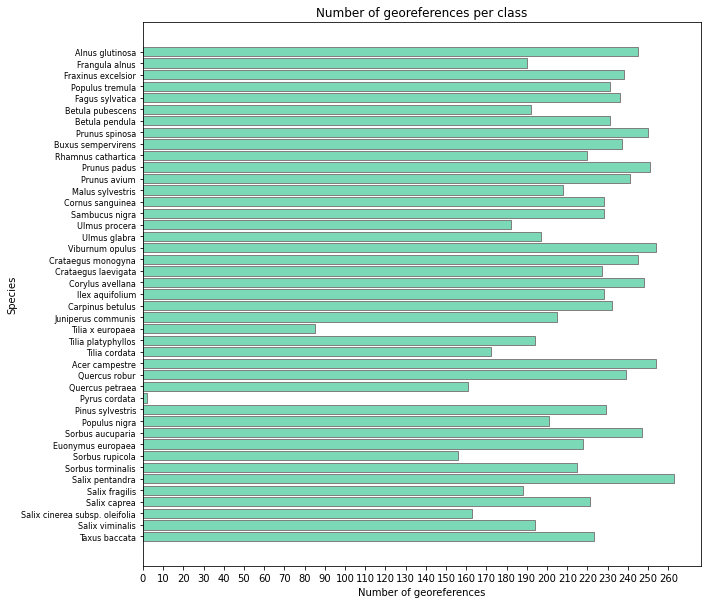

In [104]:
def get_species_list(df):
    return df["species_name"].tolist()

def get_occurrence_count(item_list):
    item_count = []
    unique_items = unique(item_list)
    for item in unique_items:
        item_count.append(item_list.count(item))
    return item_count

def unique(item_list):
    unique_list = []
    for item in item_list:
        if item not in unique_list:
            unique_list.append(item)
    return unique_list

def plot_coordenates_count(occurrence_count, species_name, path_to_plot):
    """
    Plot number of coordenates per class.
    """
    occurrence_count = list(reversed(occurrence_count))
    species_name = list(reversed(species_name))
    plt.figure(figsize=(10,10)) 
    plt.barh(species_name, occurrence_count, color="#7cd9b7", height=0.8, edgecolor="grey")
    plt.title("Number of georeferences per class")
    # x axis, species
    xint = range(0,(max(occurrence_count)+1),10)
    plt.xticks(xint)
    plt.xlabel("Number of georeferences")
    # y axis, image count
    plt.ylabel("Species", rotation="vertical")
    plt.yticks(fontsize=8)
    # save file
    plt.savefig(path_to_plot)

species_name = unique(get_species_list(dataset))
occurrence_count = get_occurrence_count(get_species_list(dataset))   
plot_coordenates_count(occurrence_count, species_name, os.path.join(save_dir, "occurrences_per_class.png"))

There is class imbalance. I suggest eliminating Pyrus cordata class.

No handles with labels found to put in legend.


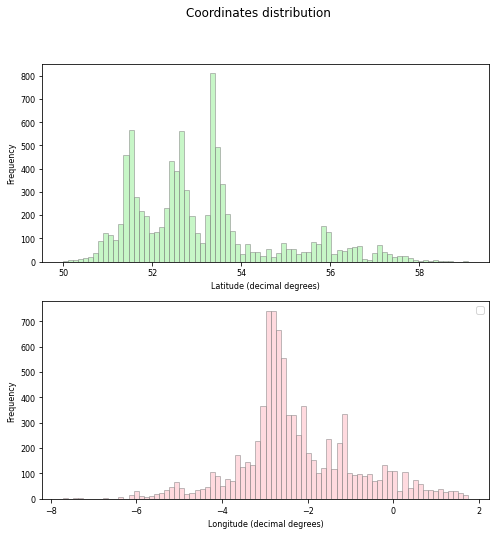

In [105]:
def column_to_list(df, column):
    """
    Return a list of elements of column from a data frame.
    Args.: a dataframe and a name of a column.
    """
    try:
        return df[column].tolist()
    except:
        print(f"Unable to extract {column} from {df}.")

def plot_coordinates_frequency(coordinates_df, destination_path):
    """
    Return an histogram with the frequency of the coordinates.
    Arg.: a data frame with latitude and longitude
    """
    latitude = column_to_list(coordinates_df, "latitude")
    longitude = column_to_list(coordinates_df, "longitude")
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(8, 8))
    #fig, axs = plt.subplots(2)
    fig.suptitle('Coordinates distribution')
    plt.subplot(2,1,1)
    plt.hist(latitude, bins = 80, alpha = 0.5, 
             color="lightgreen", 
             edgecolor="grey")
    plt.ylabel("Frequency", fontsize=8)
    plt.xlabel("Latitude (decimal degrees)", fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.subplot(2,1,2)
    plt.hist(longitude, bins = 80, alpha = 0.5, 
            color="lightpink", 
            edgecolor="grey")
    plt.ylabel("Frequency", fontsize=8)
    plt.xlabel("Longitude (decimal degrees)", fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend()
    plt.savefig(destination_path)
    
plot_coordinates_frequency(dataset,os.path.join(save_dir, "histogram.png"))

/home/sciapps/Documents/Repos/tfm/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/sciapps/Documents/Repos/tfm/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


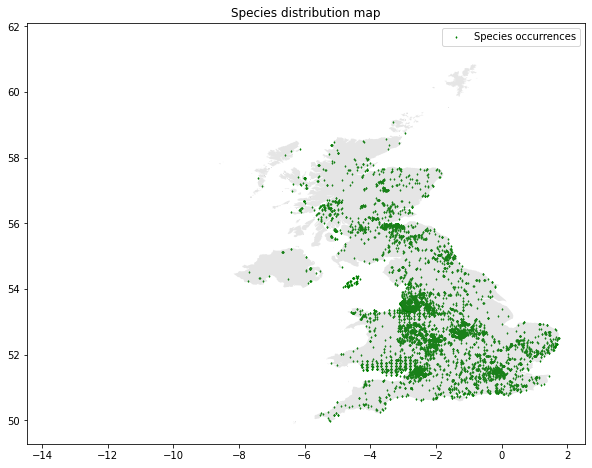

In [106]:
# UK map
shape_file = os.path.join(local_path,"data/geodata/uk_maps/GBR_adm0.shp") # UK map

def plot_occurrences_map(coordinates_df, shape_file, destination_path):
    """
    Return an occurrences map in .png format.
    Args.: a shape file for a geographical area
    and a dataframe with at least two columns:
    - latitude
    - longitde
    and a path where to save the map.    
    """
    # Add a new column to the data frame with a combination of coordinates
    coordinate_pair = [Point(xy) for xy in zip(coordinates_df.longitude, coordinates_df.latitude)]
    geometry_df = coordinates_df[["species_name"]]
    geometry_df['geometry'] = coordinate_pair  
    crs = {'init': 'epsg:4326'}
    occurrences_loc = gpd.GeoDataFrame(geometry_df, crs=crs, geometry=coordinate_pair)
    occurrences_loc.shape
 
    shape_map = gpd.read_file(shape_file)
    fig, ax = plt.subplots(figsize = (10,10))
    occurrences_loc.geometry.plot(marker="d", color="green", markersize=1, ax=ax, label = "Species occurrences")
    shape_map.plot(color="grey", ax=ax, alpha = 0.2)
   
    plt.title('Species distribution map')
    plt.legend()
    plt.savefig(destination_path)
    
plot_occurrences_map(dataset, shape_file,os.path.join(save_dir, "occurrences_map.png"))

In [119]:
# UK map
shape_file = os.path.join(local_path,"data/geodata/uk_maps/GBR_adm0.shp") # UK map
from random import randint
def plot_clustered_occurrences_map(coordinates_df, shape_file, destination_path, species_list):
    """
    Return an occurrences map in .png format.
    Args.: a shape file for a geographical area
    and a dataframe with at least two columns:
    - latitude
    - longitde
    and a path where to save the map.    
    """
    coordinates_df = coordinates_df.loc[coordinates_df["species_name"].isin(species_list)]
    
    # Add a new column to the data frame with a combination of coordinates
    coordinate_pair = [Point(xy) for xy in zip(coordinates_df.longitude, coordinates_df.latitude)]
    geometry_df = coordinates_df.iloc[:,[0]]
    geometry_df["geometry"] = coordinate_pair  
    crs = {"init": "epsg:4326"}
    occurrences_loc = gpd.GeoDataFrame(geometry_df, crs=crs, geometry=coordinate_pair)
    occurrences_loc.shape
    shape_map = gpd.read_file(shape_file)    
    fig, ax = plt.subplots(figsize = (15,15))
    shape_map.plot(color="grey", ax=ax, alpha = 0.2)
    
    # Generating and array of random colors with length equals to number of unique species
    # Based on: https://stackoverflow.com/questions/7827530/array-of-colors-in-python
    number_species = occurrences_loc["species_name"].nunique() # Getting the number of unique species
    colors = []
    color_count = 0
    for i in range(number_species):
        colors.append('#%06X' % randint(0, 0xFFFFFF))
    for species_name in occurrences_loc["species_name"].unique():
        occurrences_loc[occurrences_loc["species_name"] == species_name].geometry.plot(
            marker="o", color=colors[color_count], 
            markersize=15, 
            edgecolors="grey",
            ax=ax, 
            alpha = 0.5,
            label = species_name)
        color_count += 1

   
    plt.title('Species distribution map')
    plt.legend()
    plt.savefig(destination_path)

/home/sciapps/Documents/Repos/tfm/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sciapps/Documents/Repos/tfm/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


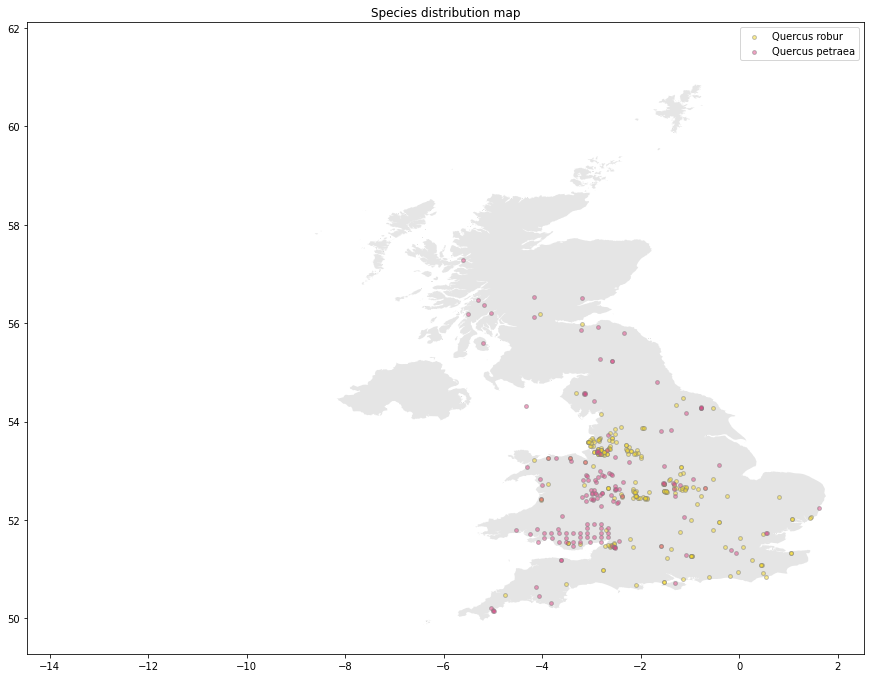

In [118]:
species_list = ["Quercus robur", "Quercus petraea"]
plot_clustered_occurrences_map(dataset, shape_file,os.path.join(save_dir, "clustered_occurrences_map.png"), species_list)

/home/sciapps/Documents/Repos/tfm/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sciapps/Documents/Repos/tfm/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


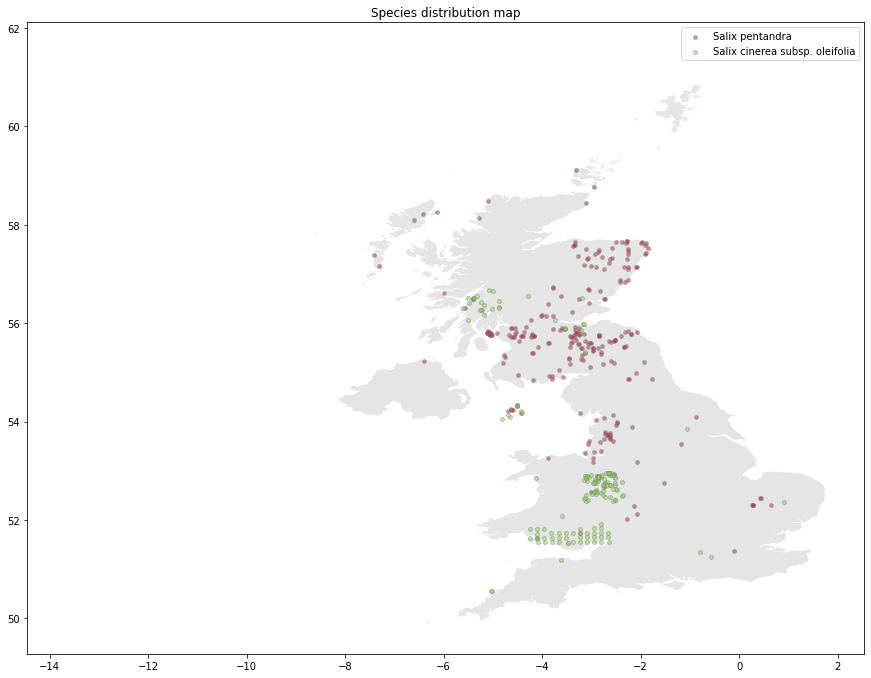

In [124]:
species_list = ["Salix pentandra", "Salix fragilis", "Salix caprea", "Salix cinerea subsp. oleifolia"]
species_list = ["Salix pentandra", "Salix cinerea subsp. oleifolia"]
plot_clustered_occurrences_map(dataset, shape_file,os.path.join(save_dir, "clustered_occurrences_map.png"), species_list)

/home/sciapps/Documents/Repos/tfm/env/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sciapps/Documents/Repos/tfm/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


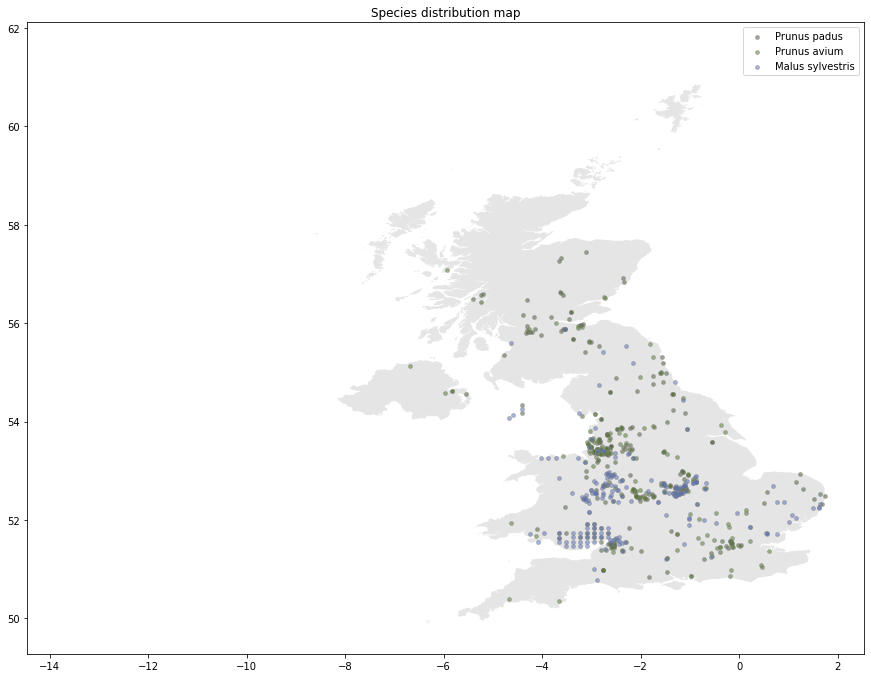

In [76]:
species_list = ["Prunus padus", "Prunus avium"]
species_list = ["Tilia cordata", "Tilia platyphyllos", "Tilia x europaea"]
species_list = ["Crataegus laevigata", "Crataegus monogyna"]
species_list = ["Sorbus rupicola", "Sorbus torminalis"]
species_list = ["Malus sylvestris", "Prunus padus", "Prunus avium"]

plot_clustered_occurrences_map(dataset, shape_file,os.path.join(save_dir, "clustered_occurrences_map.png"), species_list)

In [69]:
# LABELS
class_names = list(set(column_to_list(dataset, "species_name")))
print(f"{len(class_names)} classes in dataset.")
print(f"Classes names: {class_names}")

43 classes in dataset.
Classes names: ['Quercus robur', 'Buxus sempervirens', 'Alnus glutinosa', 'Viburnum opulus', 'Frangula alnus', 'Malus sylvestris', 'Quercus petraea', 'Ilex aquifolium', 'Betula pendula', 'Pinus sylvestris', 'Salix fragilis', 'Fagus sylvatica', 'Acer campestre', 'Fraxinus excelsior', 'Prunus spinosa', 'Euonymus europaea', 'Corylus avellana', 'Prunus padus', 'Tilia cordata', 'Ulmus procera', 'Juniperus communis', 'Pyrus cordata', 'Crataegus monogyna', 'Populus tremula', 'Cornus sanguinea', 'Crataegus laevigata', 'Carpinus betulus', 'Sorbus rupicola', 'Salix pentandra', 'Tilia platyphyllos', 'Salix caprea', 'Populus nigra', 'Sorbus aucuparia', 'Sambucus nigra', 'Salix viminalis', 'Betula pubescens', 'Sorbus torminalis', 'Ulmus glabra', 'Salix cinerea subsp. oleifolia', 'Tilia x europaea', 'Prunus avium', 'Taxus baccata', 'Rhamnus cathartica']


In [ ]:
# EDIT FOR EACH MODEL
# Model description
model_description = f"""
{model_name}

"""

# Save model description
with open(os.path.join(save_dir,"model_description.txt"), "w") as file:
    with redirect_stdout(file):
        print(model_description)

## Retrieving the data from the dataset 

In [ ]:
# Encode class names
class_names.sort()
species_to_number = {species_name:class_names.index(species_name) for species_name in class_names}
species_to_number

In [ ]:
dataset['target']=dataset.apply(lambda r:species_to_number[r.species_name],axis=1)
dataset.sample(n=5)

In [ ]:
dataset_num = dataset.drop(columns="species_name")
dataset_num.sample(n=5)

In [ ]:
train, test = train_test_split(dataset_num, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')


In [ ]:
train.sample(n=5)

In [ ]:
# Predictors (latitude and longitude)
X_train = train.iloc[:, 1:3].values  
X_val = val.iloc[:, 1:3].values 
X_test = test.iloc[:, 1:3].values 
print(f"Train predictor shape: {X_train.shape}")
print(f"Validation predictor shape: {X_val.shape}")
print(f"Test predictor shape: {X_test.shape}")
print(X_train)

In [ ]:
y_train = train.iloc[:, 2].values  
y_val = val.iloc[:, 2].values 
test_labels = test.iloc[:, 2].values 

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(test_labels)
print(f"Train target shape: {y_train.shape}")
print(f"Validation target shape: {y_val.shape}")
print(f"Test target shape: {y_test.shape}")
print(y_train)

## Features normalization

In [ ]:
dataset_not_norm = dataset.drop(columns="target")
dataset_not_norm.boxplot()

In [ ]:
# Effect of features normalization
x = dataset_not_norm.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset_norm = pd.DataFrame(x_scaled)
dataset_norm.boxplot()

In [ ]:
X_train_norm = normalize(X_train)
X_val_norm = normalize(X_val)
X_train_norm

## Creating and training the model

### Model network architecture

The simplest network architecture constists of 3 layers:

- Input layer, with a number of nodes equal to the number of features in the model.
- Hidden layer, with a variable number of nodes. 
- Output layer, with a number of nodes equal to the number of classes. 

#### The hidden layers

The hidden layers can have different characteristics depending of their use. 
The transformations applied by the convolutional layers have shown the best results for image classification, so they will be the main component in this model.


##### The fully connected layer

A fully connected layer is an all purpose layer where each node receive the inputs from all the nodes from the previous layer, multiplied by their weights, sumed and transformed by the activation funcion.

In keras, the fully connected layer is called `Dense`.



### Creating and training the model with `Keras`

In `Keras` the model is defined with the `Sequential` method as a linear stack ot layers. The **input layer** is implicit in the first layer (a network with 3 layers will have 2 in `keras Sequential` method).

The **input shape** is into the first layer. The model inputs are the tensors or arrays. Images have 3 dimensions: **width**, **height** and **channels**. The width and the height are measured in pixels and the channels reference the color values (the channel value is 1 if it is in black and white and 3 if it is color in RGB (Red, Green, blue) or HSV (hue, saturation, value) formats - 2 and 4 are black and white or color with an alpha channel (transparency). 

The **activation function** that has to be specified in each layer transforms the input data so that the output doen't have a linear relation with the input. 

In [ ]:
model = Sequential()
tf.keras.layers.Flatten(input_shape=(X_train_norm.shape[-1],))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(len(class_names), activation='softmax'))

In [ ]:
# Compiling the ANN
#opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# Early stopping (when loss does not fall anymore to avoid overfitting)
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience = 50)

# Checkpoint to save model weights and history before it stops training
checkpoint_filepath = os.path.join(save_dir, "/tmp/checkpoint")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath,
                                                              save_weights_only = True,
                                                              monitor= "val_acc",
                                                              save_best_only = True)

In [ ]:
epochs = 500
history = model.fit(
        X_train_norm,
        y_train,
        validation_data=(X_val_norm, y_val),
        batch_size = 10, 
        epochs = epochs
    )

In [ ]:
# Save model history to csv
history_df = pd.DataFrame(history.history) 
history_df.to_csv(os.path.join(save_dir, "model_history.csv"), sep=",", index=False)

# Save model weights
model.save_weights(os.path.join(save_dir, "weights.h5")) 

### Evaluating the model training

#### Accuracy and loss during training

In [ ]:
# Parameters measured during model training
history_dict = history.history
print(history_dict.keys())

In [ ]:
try:
    acc = history_dict["acc"]
    val_acc = history_dict["val_acc"]
    loss = history_dict["loss"]
    val_loss = history_dict["val_loss"]
except:
    try:
        acc = history_dict["accuracy"]
        val_acc = history_dict["val_accuracy"]
        loss = history_dict["loss"]
        val_loss = history_dict["val_loss"]
    except:
        pass        

In [ ]:
def plot_acc_loss(acc,val_acc,loss,val_loss,epochs):
    epochs_range = range(epochs)
    plt.figure(figsize=(8, 8))
    plt.suptitle(model_name)
    # Accuracy plots
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    # Loss plots
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss") 
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.savefig(os.path.join(save_dir,"acc_loss_plot.png"))
    plt.show()

In [ ]:
plot_acc_loss(acc,val_acc,loss,val_loss,epochs)

#### Overfitting

When the model predicts significantly better the training set than the validation set, it is a sign of overfitting. 

### Reuse model outputs

To load the model again, it has to be built and then the weights added:

```
# load pre-trained model with the weights
vgg16_model = tf.keras.applications.VGG16()
# Add the layers of vgg16 model to a new sequential model 
model = Sequential()
for layer in vgg16_model.layers[:-1]: # remove last layer
    model.add(layer)
# Freeze the weights in the layers
for layer in model.layers:
    layer.trainable = False
# Add last layer for categories
model.add(Dense(len(class_names), activation = "softmax"))  

cnn.load_weights(os.path.join(save_dir, "model.h5"))
```

To get back the accuracy and loss data:

- Open the CSV with the model history.
- Save it to a dictionary.

```
history_df = pd.read_csv(os.path.join(save_dir, "model_history.csv"))
history_dict = history_df.to_dict()
try: # the key names vary across tf versions
    acc = np.array(list(history_dict["acc"].values()))
    val_acc = np.array(list(history_dict["val_acc"].values()))
    loss = np.array(list(history_dict["loss"].values()))
    val_loss = np.array(list(history_dict["val_loss"].values()))
    epochs_range = np.array(range(epochs))
except:
    try:
        acc = np.array(list(history_dict["accuracy"].values()))
        val_acc = np.array(list(history_dict["val_accuracy"].values()))
        loss = np.array(list(history_dict["loss"].values()))
        val_loss = np.array(list(history_dict["val_loss"].values()))
        epochs_range = np.array(range(epochs))
    except:
        pass
plot_acc_loss(acc,val_acc,loss,val_loss,epochs)
```

## Evaluating the model

### Get the test dataset

In [ ]:
def test_labels_to_index(test_labels, class_names):
    """
    Return a 1D array of integers with the corresponding
    number for a class.
    Args.: - A list with the class name of each item in 
          the test data set.
           - A sorted list with the possible class names. 
    Eg.: test_labels[1] = "Buxus_sempervirens" corresponds to index 4
         in the list of class names.
    """
    test_labels_index = []
    for i in range(len(test_labels)):
        ind = class_names.index(test_labels[i])
        test_labels_index.append(ind)
    return np.array(test_labels_index)

In [ ]:
test_files = os.listdir(test_dir)
test_labels = get_test_labels(test_files)
test_labels[:5]

In [ ]:
test_labels_index = test_labels_to_index(test_labels, class_names)
test_labels_index[:5]

### Predict the probability of classifiying each class

In [ ]:
# Get the probability of predicting each class for each image
predictions = model.predict(X_test, batch_size = 1)

Predictions is a 2D array with a shape: (number of examples in test, number of classes)

In [ ]:
predictions.shape

In [ ]:
# Get predicted class for each example
def predicted_class(predictions):
    """
    Return a 1D array with the predicted class for each example.
    Arg.: 2D array predictions of shape (number of examples, number of classes)
    """
    pred_class = []
    for i in range(len(predictions)):
        higher_prob = max(predictions[i])
        ind, = np.where(np.isclose(predictions[i], higher_prob))
        pred_class.append(ind[0])
    return np.array(pred_class)

pred_class = predicted_class(predictions)

### Plot the confussion matrix

In [ ]:
test_labels

In [ ]:
pred_class

In [ ]:
# Build the confusion matrix
cm = tf.math.confusion_matrix(test_labels, pred_class) 
# Convert from tensor to array
sess = tf.Session()
conf_mat = sess.run(cm)
conf_mat

In [ ]:
def plot_confusion_matrix(cm, class_names, model_name):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuGn)
    plt.title("Confusion matrix - "+ model_name, fontsize = 22)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    plt.xlabel("Predicted", fontsize = 18)
    plt.ylabel("Actual", fontsize = 18)
    plt.savefig(os.path.join(save_dir,"conf_matrix.png"))


In [ ]:
plot_confusion_matrix(conf_mat, np.array(class_names), model_name)